# Overview

This week is about two topics. Decision trees and clustering. The main exercise will be on decision trees, and we'll also talk a bit about unbalanced data sets as well as a little exercise on clustering, an example of unsupervised learning. Before we get started, we'll talk about workload, however. 

In [53]:
# Imports
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import cluster
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from __future__ import division
import random

In [ ]:
# Load data
df = pd.read_csv('../data/SFPD_Incidents_-_from_1_January_2003.csv', sep=',')

## Part 0: Discussing the course workload

Last week we talked about what could be better with the class and some of you guys mentioned that parts of the class are a lot of work. So this week we'll start an investigtion of that. Below, I'm including a Google form to collect some data on the matter. I ask a few additional questions because I want to understand how your background plays influences the answers. 

I'll do an analysis of your answers and tell you about the findings next week.

In [1]:
from IPython.display import IFrame, YouTubeVideo
IFrame("https://docs.google.com/forms/d/1VsgNpMMQk-sZoZD2pxeXmKFXfnhZ0EGwvQ3YDNZbGwA/viewform?embedded=true", 
       width=600, height=400)

# I'm not showing the entire questionnaire in the iframe below, but you should be able to scroll within the frame.

## Part 1: Decision trees (DSFS Chapter 17)

> _Reading I_: The visual introduction to decision trees on [**this webpage**](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/
) is AMAZING. Take a look to get an intuitive feel for how trees work. Do not miss this one, it's a treat!

---

> _Reading II_: DSFS Chapter 17. Work through chapter 17 of the book. It's not as flashy as the fancy `D3.js` based web-explanation, but it's very good (in my humble opinion).

In [2]:
# Ole explains decision trees
YouTubeVideo("LAA_CnkAEx8",width=600, height=300)

> _Exercises_: Just a few questions to make sure you've read the text and/or watched the video.
>
> * There are two main kinds of decision trees depending on the type of output (numeric vs. categorical). What are they?

Classification and regression trees

> * Explain in your own words: Why is _entropy_ useful when deciding where to split the data?

Because it signifies uncertanity

> * Why are trees prone to [overfitting](https://www.youtube.com/watch?v=DQWI1kvmwRg)?

They are prone to overfitting since they optimize the split of data greedily over the "best" covariate

> * Explain (in your own words) how random forests help prevent overfitting.

Random forests prevent overfitting by introducing random fitting on subsets of the data and voting to find the best result

Chief Suneman arrives at work one day and immediately starts motivating the team by randomly yelling at everyone in order to increase morale - something like [this](https://www.youtube.com/watch?v=L_QCioSGgwU). After a while, the team gets him calmed down with a cup of coffee and a movie. It doesn't help, after watching the first 10 minutes (see below) he comes out of his office with an outrageous request for the newly appointed data science team

In [3]:
YouTubeVideo("BmSarhudhiY",width=600, height=300)

The chief wants you to start from real data and build a system that replicates the functionality in the _Minority Report_ system. Imagine, we find out that certain type of crime is going to take place - as well as the exact time of the crime - **but that we don't know _where_**, then Suneman wants an algorithm that will predict which district the crime is most likely to take place in. Specifically, let's build an algorithm that predicts the location of a crime based on its type and time.

The friendly leader of the data-science team, Captain Mones, helps break down the task.

> _Exercise_: Building the _minority report_ algorithm
>
> * Use the category of the crimes to build a decision tree that predicts the corresponding district. You can implement the ID3 tree in the DSFS book, or use the [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/tree.html) class in scikit-learn. For training, you can use 90% of the data and test the tree prediction on the remaining 10%. 
>  - What is the fraction of correct predictions? 
>  - What are the correct predictions if you restrict the training/prediction to single districts (for example, predicting Mission vs. all other districts, etc)? 
>   - Compare it to the random guess, what would you get if you'd guess a district randomly? 
>   - And if you'd guess always one of the districts (for example the district with the most crimes)?
> * Now, add the day of the week to the features, do any of the the performance measures improve? 
> * Let's try some examples to see if the algorithm is working. 
>  - There is a new crime (prositution) on Monday 10pm. What are the three most likely districts? 
>  - Also find the most likely districts for a gambling on Wednesday 1pm. 
>  - And also try out an arson case on Sunday 7am?
> * Visualize the tree so that you can see what it actually does! For visualization, you can use the export_graphviz method of `scikit-learn` and then convert the `.dot` file to a PDF. 
>   - Note: [in order to use GraphViz in IPython, you need to install it on your system first](http://www.graphviz.org/Download..php)!
> * As you might see in the visualization, the tree runs out of possible feature values to check before refining the decision. Try increasing the number of features: add part of the day (`night`=0-5, `morning`=6-10, `midday`=11-14, `afternoon`=15-17, `evening`=18-23). Is it better? What happens if you don't break the day into parts but use raw hour values?
> * It's unlikely that the classifier overfits in our case. Explain why. 

In [9]:
# Sample 90% of the incidents for use to training and the rest for validation
training = df.sample(frac = 0.9)
validation = df.loc[~df.index.isin(training.index)]

In [120]:
# Create one hot encoded data from feature set
def oneHotEncode(data, features):
    featdict = {feature:ix for ix, feature in enumerate(features)}
    output = np.zeros( (len(data), len(features)) )
    for d in enumerate(data):
        output[d[0], featdict[d[1]]] = 1
    return pd.DataFrame(output, columns=features, index=data.index)

categoryEncoding = list(set(df.Category))

# Predict diastrict
X = oneHotEncode(training.Category, categoryEncoding)
target =  training.PdDistrict
mdl= tree.DecisionTreeClassifier().fit(X, target)

In [70]:
pred = mdl.predict(oneHotEncode(validation.Category, categoryEncoding))
print "Correctly predicted %.4f" % (sum([p==t for p,t in zip(pred, validation.PdDistrict)])/len(pred))
print mdl.get_params(deep=True)

Correctly predicted 0.0000
{'presort': False, 'splitter': 'best', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': None, 'max_depth': None, 'class_weight': None}


In [52]:
# predict single district from the rest
X = oneHotEncode(training.Category, categoryEncoding)
target =  training.PdDistrict == 'MISSION'
mdl= tree.DecisionTreeClassifier().fit(X, target)
pred = mdl.predict(oneHotEncode(validation.Category, categoryEncoding))
print "Correctly predicted %.4f" % (sum([p==t for p,t in zip(pred, validation.PdDistrict == 'MISSION')])/len(pred))

Correctly predicted 0.8644


In [61]:
# Random guess
districts = list(set(df.PdDistrict))
print "Correctly predicted %.4f" % (sum([random.choice(districts) == t for t in validation.PdDistrict])/len(validation))

Correctly predicted 0.0919


In [68]:
# always most crime ridden
mcr = Counter(training.PdDistrict).most_common()[0][0]
print "Correctly predicted %.4f" % (sum([mcr == t for t in validation.PdDistrict])/len(validation))

Correctly predicted 0.1799


## Adding day of week to decision tree

In [71]:
Days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
X = oneHotEncode(training.Category, categoryEncoding).join(
    oneHotEncode(training.DayOfWeek, Days))
target =  training.PdDistrict
mdl1 = tree.DecisionTreeClassifier().fit(X, target)

In [72]:
X = oneHotEncode(validation.Category, categoryEncoding).join(
    oneHotEncode(validation.DayOfWeek, Days))
target =  validation.PdDistrict
pred = mdl1.predict(X)
print "Correctly predicted %.4f" % (sum([p==t for p,t in zip(pred, target)])/len(pred))

Correctly predicted 0.2039


Improves the score a little bit, but not much since there might not be a big correlation between day and district

## Adding Hours as well

In [125]:
# extract hours from time string
def extractHour(df): 
    return df.Time.apply(lambda t: int(t.split(':')[0]))

X = oneHotEncode(training.Category, categoryEncoding).join(
    oneHotEncode(training.DayOfWeek, Days)).join(
    extractHour(training))
target =  training.PdDistrict
#mdl2 = tree.DecisionTreeClassifier().fit(X, target)

X = oneHotEncode(validation.Category, categoryEncoding).join(
    oneHotEncode(validation.DayOfWeek, Days)).join(
    extractHour(validation))
target =  validation.PdDistrict
pred = mdl2.predict(X)
print "Correctly predicted %.4f" % (sum([p==t for p,t in zip(pred, target)])/len(pred))

Correctly predicted 0.2040


Adding hour gave even less results

## probabilities of given entries

In [158]:
def toEncoding(categoryList, dayList, hourList):
    return oneHotEncode(pd.DataFrame(categoryList)[0], categoryEncoding).join(
            oneHotEncode(pd.DataFrame(dayList)[0], Days)).join(
            pd.DataFrame(hourList, columns=['Hour']))

X = toEncoding(['PROSTITUTION', 'GAMBLING', 'ARSON'], ['Monday', 'Wednesday', 'Sunday'], [10, 13, 7])
pd.DataFrame(mdl2.predict_proba(X), columns=mdl.classes_)


,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,0.050000,0.00,0.05,0.600000,0.20,0,0.000000,0.000000,0.05,0.05
1,0.250000,0.25,0.00,0.250000,0.25,0,0.000000,0.000000,0.00,0.00
2,0.666667,0.00,0.00,0.083333,0.00,0,0.166667,0.083333,0.00,0.00


In [169]:
from sklearn.externals.six import StringIO
with open("output/w5dc3.dot", 'w') as f:
    f = tree.export_graphviz(mdl2, out_file=f)

SyntaxError: EOL while scanning string literal (<ipython-input-169-a5904a077695>, line 5)

Dot files can be transformed to pdf with the following terminal command  
`dot -Tpdf output/w5dc3.dot -o output/w5dc3.pdf`  

It is unlikely to overfit the data since we have a lot of data points, and quite few features

### Digression: Decision trees and unbalanced data

An important problem in many data-science problems is _unbalanced data_. We consider a dataset balanced when the categories we care about have about equal size (e.g. if we want to predict the gender of individuals in the general population). When the category size are imbalanced (e.g. if we are looking for people with a rare disease such as _leukemia_ in the general population), many machine learning algorithms can have problems.

> _Reading_: [This article](http://arstechnica.co.uk/security/2016/02/the-nsas-skynet-program-may-be-killing-thousands-of-innocent-people/) does a great job of explaining the problem.

---

> _Exercises_: I know you read the article above, but just a few questions to make you reflect on the details of the story.
> 
> * Explain what features go into the terrorist detection model

Phone data etc. Like sensible :P

> * Which algorithm is used to detect the terrorists?

Random forests decision trees

> * Do you agree with the algorithm that Al-Jazeera bureau chief is a good target? Justify your answer.

No, but his travel pattern and large network may be a contributing factor to him being classified

> * What's the size of the training set?

Very few confirmed positives (terrorists)

> * Why is it still a problem that the algorithm has a false alam rate at 0.18% at a 50% miss rate?

Because the proportion of negatives is much larger than the positives
if 1/100 is assumed 18% are falsely accused while still only finding every second terrorist

> * Do you have a better grasp of the problems with overfitting after reading this article?

Yes!

## Part 2: Clustering (DSFS Chapter 19)

Clustering is an important _unsupervised_ method to reveal structure in the data. You've already done a lot of hard work today, so let's make this one as easy as possible.

> _Reading_: Check out chapter 19 of DSFS

In [172]:
# Ole talks about clustering
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo("G7jYVrCVygU",width=600, height=300)

In this exercise we explore $K$-means clustering - and we it out on the locations of the `PROSTITUTION` crime type. Applying a clustering method makes sense because we know from our earlier work that this crime type tends to happen in only a few locations. We'll also talk a little bit about model selection and [overfitting](https://www.youtube.com/watch?v=DQWI1kvmwRg) in unsupervised models.

> _Exercise_: $K$-means
> 
> * Visualize the prostitution data (e.g. by plotting it on a map)
> * Train models of $K = 2,\ldots,10$ on the prostitution data.
> * Explore how the total squared error changes as a function of $K$ and identify what you think is the right number of clusers based on the knee-point in the squared error plot.
> * And by the way: The fit only gets better when we add more means - why not keep adding more of them: Explain in your own words why it makes sense to stop around a knee-point.
> * Another way of estimating the right number of clusters in a $K$-means problem is _stability analysis_. The idea is the following
>   - For each $K = 2,\ldots,10$ generate $N = 10$ clusterings based on random 50% of data (or some other fraction of data/bootstrap).
>   - Calculate the pairwise similarity between the clusterings. 
>   - We now define _stability_ for some value of $K$ as average pairwise similarity of the $N$ clustering, where the similarity is the cosine distance $\frac{\mathbf{c}_i^K\cdot\mathbf{c}_j^K}{||\mathbf{c}_i^K||\,||\mathbf{c}_j^K||}$ between centroid vectors $\mathbf{c}_i^K$ and $\mathbf{c}_j^K$.
>   - We now say that the right $K$ maximizes stability.
> * Explain why stability should help you find the right number of clusters.
> * **Optional**: Perform stability analysis on the prostitution data. 

In [211]:
import geoplotlib
from geoplotlib.utils import BoundingBox

mask = (df.Y != 90) & (df.Category == 'PROSTITUTION')

geodata = {"lat": df.loc[mask].Y.tolist(),
           "lon": df.loc[mask].X.tolist()}
geoplotlib.kde(geodata, bw=5, cut_below=1e-2);

geoplotlib.tiles_provider('toner-lite');
geoplotlib.set_bbox(BoundingBox(max(geodata['lat']), max(geodata['lon']), min(geodata['lat']), min(geodata['lon'])));
geoplotlib.inline();

('smallest non-zero count', 7.1647865443840454e-10)
('max count:', 10.918591925127725)


In [252]:
X = df.loc[mask][['X','Y']]
mdl3 = cluster.KMeans(n_clusters=3).fit(X)

centroids = {"lat": mdl3.cluster_centers_[:,1],
           "lon": mdl3.cluster_centers_[:,0]}
geoplotlib.kde(geodata, bw=5, cut_below=1e-2);
geoplotlib.dot(centroids, color ='b', point_size=5);

geoplotlib.tiles_provider('toner-lite');
geoplotlib.set_bbox(BoundingBox(max(geodata['lat']), max(geodata['lon']), min(geodata['lat'])-0.05, min(geodata['lon'])));
geoplotlib.inline();

('smallest non-zero count', 1.4329573088768091e-09)
('max count:', 17.065636267483391)


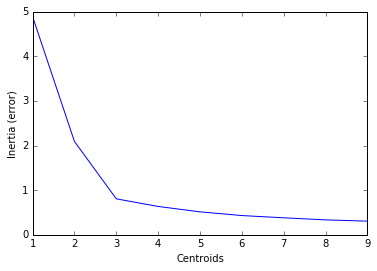

In [251]:
kmean = [cluster.KMeans(n_clusters=cenx).fit(X).inertia_ for cenx in range(1,10)]
plt.plot(range(1,10), kmean)
plt.xlabel('Centroids');
plt.ylabel('Inertia (error)');

Knee point around three clusters (one for each of the hotspots and one for the outliers)